In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
jax.default_backend()

'cpu'

In [133]:
#generate data

x_s = np.linspace(-4,4, 10)
y_s = np.linspace(-4,4, 10)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    X.append(state)

X_grid = np.array(X)
y_grid = np.array(y)
len(X_grid)


1500

In [134]:
env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(1000):
    state = env.reset()
    X.append(state)
    for action in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, action, update_env=False)
        X.append(next_state)


X = np.array(X)


In [135]:
X = np.vstack([X, X_grid])
np.random.shuffle(X)
len(X)

5500

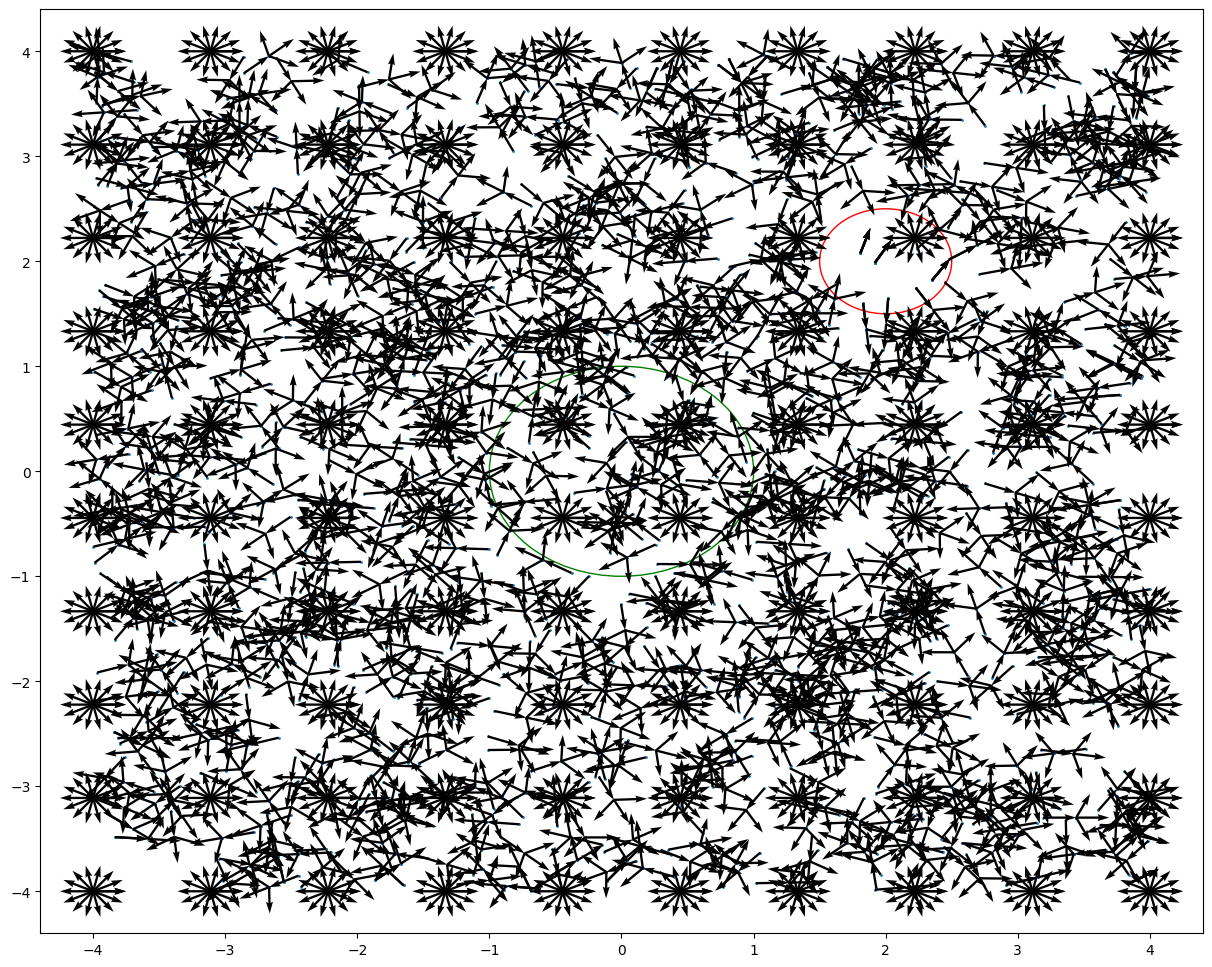

In [136]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 12]

# Plot...
plt.scatter(X[:,0], X[:,1], s=1) # s is a size of marker 
        # draw goal
goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

# draw obstacle
obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
plt.gca().add_artist(obstacle)
plt.gca().add_artist(goal)


arrow_len = env.v_max
# Calculate arrow components
arrow_dx = arrow_len * np.cos(X[:,2])
arrow_dy = arrow_len * np.sin(X[:,2])
plt.quiver(X[:,0], X[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color='k')


plt.jet()
#plt.show()
plt.savefig('env.png')

In [123]:
np.max(X[:,2])

6.2831855

In [124]:
2*np.pi

6.283185307179586

In [125]:
jax.local_device_count()

1

In [137]:
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X


array([[ 2.9252067 ,  0.9967002 , -0.19831114, -0.98013914],
       [-0.3432981 ,  2.4424984 ,  0.21836177,  0.97586787],
       [-1.4384224 ,  0.42624336, -0.39533508, -0.91853696],
       ...,
       [ 2.105242  ,  1.0008744 ,  0.86326534,  0.50475043],
       [ 3.1111112 ,  2.2222223 ,  1.        ,  0.        ],
       [ 1.7539792 ,  0.445975  , -0.3675416 , -0.9300071 ]],
      dtype=float32)

In [126]:
# import numpy as np

# def circular_positional_encoding(theta, d):
#     """
#     Encode a periodic variable using circular positional encoding.

#     Args:
#         theta (float): The value of the periodic variable to encode, in radians.
#         d (int): The number of dimensions in the encoded space.

#     Returns:
#         A numpy array of shape (d,) representing the encoded value.
#     """
#     assert theta >= 0 and theta <= 2*np.pi + 0.001, "theta must be between 0 and 2pi"
#     assert d % 2 == 0, "d must be an even number"

#     i = np.arange(d//2)
#     encoding = np.zeros((d,))
#     encoding[::2] = np.sin(theta * 2**i / (2*np.pi))
#     encoding[1::2] = np.cos(theta * 2**i / (2*np.pi))
#     return encoding

# # Example usage:
# d = 32 # The number of dimensions in the encoded space
# X_encoded = np.array([list(row[:2]) + list(circular_positional_encoding(row[2], d)) for row in X])
# print(X_encoded)



[[ 2.97563934 -2.24937797  0.43962601 ...  0.90686513 -0.76434397
   0.64480872]
 [-2.12429428 -1.88280618  0.17605149 ... -0.98868776 -0.29658332
   0.95500698]
 [ 0.3518523   0.97904539  0.66953342 ...  0.73078772 -0.99767841
   0.0681014 ]
 ...
 [ 0.44444445  1.33333337  0.80076507 ... -0.52425498 -0.89287055
  -0.45031342]
 [-3.53769565 -2.43080115  0.41257836 ...  0.97592423 -0.42571733
   0.90485621]
 [-1.51360154  1.01021075  0.63082842 ...  0.99985561 -0.03398044
   0.9994225 ]]


In [127]:
X=X_encoded

In [205]:
X.shape

(5500, 4)

In [208]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(16)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(1)(l2)

#     return l3.ravel()


#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(12)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(4)(l2)
    l4 = jax.nn.relu(l3)

    l5= hk.Linear(1)(l4)

    return l5
# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse


jiter = jax.jit(env.sample_value_iter)


optimizer = optax.adabelief(learning_rate=10e-6)
batch_size = 100 #make it 200-50
losses = []
#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(500):
    batch_loss = []
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.95)

    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        #print("progress:", "epoch:", epoch, "batch loss",loss)
        batch_loss.append(loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    losses.append(np.mean(batch_loss))
    print('epoch', epoch, 'average loss', np.mean(batch_loss))
        
    
    
# After training
print("estimation of the parameters:")
print(params)

# estimate  = forward(X=env.reset(), params=params)
# print("estimate", estimate)

epoch 0 average loss 11.990843
epoch 1 average loss 11.9746275
epoch 2 average loss 11.955995
epoch 3 average loss 11.938657
epoch 4 average loss 11.91997
epoch 5 average loss 11.902705
epoch 6 average loss 11.884251
epoch 7 average loss 11.867138
epoch 8 average loss 11.848966
epoch 9 average loss 11.832106
epoch 10 average loss 11.814258
epoch 11 average loss 11.797579
epoch 12 average loss 11.779945
epoch 13 average loss 11.763419
epoch 14 average loss 11.746082
epoch 15 average loss 11.729776
epoch 16 average loss 11.712747
epoch 17 average loss 11.696675
epoch 18 average loss 11.679917
epoch 19 average loss 11.663943
epoch 20 average loss 11.6473055
epoch 21 average loss 11.631417
epoch 22 average loss 11.615004
epoch 23 average loss 11.599302
epoch 24 average loss 11.583056
epoch 25 average loss 11.56749
epoch 26 average loss 11.551356
epoch 27 average loss 11.53602
epoch 28 average loss 11.520154
epoch 29 average loss 11.505108
epoch 30 average loss 11.489543
epoch 31 average lo

KeyboardInterrupt: 

In [253]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(16)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(1)(l2)

#     return l3.ravel()


#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(12)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(4)(l2)
    l4 = jax.nn.relu(l3)

    l5= hk.Linear(1)(l4)

    return l5
# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse




optimizer = optax.adabelief(learning_rate=10e-8)
batch_size = 200 #make it 200-50
losses = []
#check we aren't double using gradients
opt_state = optimizer.init(params)


@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, opt_state

for epoch in range(500):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.95)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    epoch_loss /= (len(X) // batch_size)
    losses.append(epoch_loss)
    print('epoch', epoch, 'average loss', epoch_loss)


epoch 0 average loss 14.590247
epoch 1 average loss 14.590186
epoch 2 average loss 14.590009
epoch 3 average loss 14.589946
epoch 4 average loss 14.589772
epoch 5 average loss 14.589713
epoch 6 average loss 14.589538
epoch 7 average loss 14.5894785
epoch 8 average loss 14.589303
epoch 9 average loss 14.589241
epoch 10 average loss 14.589069
epoch 11 average loss 14.589006
epoch 12 average loss 14.588831
epoch 13 average loss 14.588771
epoch 14 average loss 14.588596
epoch 15 average loss 14.588536
epoch 16 average loss 14.588362
epoch 17 average loss 14.5883
epoch 18 average loss 14.588124
epoch 19 average loss 14.588066
epoch 20 average loss 14.587891
epoch 21 average loss 14.587829


KeyboardInterrupt: 

In [227]:
# Plot the losses
lo = [l.item() for l in losses]

plt.plot(lo)

# Add a title and labels to the x and y axis
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses_3.png')

plt.show()

In [151]:
env = DubinsCarEnv()
state = env.reset()
X_val = []
for i in range(1000):
    state = env.reset()
    X_val.append(state)
    for action in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, action, update_env=False)
        X_val.append(next_state)


X_val = np.array(X_val)
X_val_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))


In [228]:
#generate data

x_s = np.linspace(-4,4, 15)
y_s = np.linspace(-4,4, 15)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid_val = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X_val = []
for i in range(len(grid_val)):
    state = env.set(grid_val[i][0], grid_val[i][1], grid_val[i][2])
    X_val.append(state)

X_val = np.array(X_val)

X_val_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))
X_val_encoded

array([[-4.0000000e+00, -4.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       [-4.0000000e+00, -4.0000000e+00,  9.0096885e-01,  4.3388376e-01],
       [-4.0000000e+00, -4.0000000e+00,  6.2348980e-01,  7.8183150e-01],
       ...,
       [ 4.0000000e+00,  4.0000000e+00,  6.2348962e-01, -7.8183162e-01],
       [ 4.0000000e+00,  4.0000000e+00,  9.0096885e-01, -4.3388376e-01],
       [ 4.0000000e+00,  4.0000000e+00,  1.0000000e+00,  1.7484555e-07]],
      dtype=float32)

In [254]:
y_pred = [forward(X=x, params=params) for x in X_val_encoded]

In [255]:
y_pred

[Array([1.3471793], dtype=float32),
 Array([1.3318473], dtype=float32),
 Array([1.2399088], dtype=float32),
 Array([1.0794233], dtype=float32),
 Array([0.8821769], dtype=float32),
 Array([0.68723655], dtype=float32),
 Array([0.5332127], dtype=float32),
 Array([0.45767933], dtype=float32),
 Array([0.47427896], dtype=float32),
 Array([0.57315326], dtype=float32),
 Array([0.73656976], dtype=float32),
 Array([0.9397284], dtype=float32),
 Array([1.1302731], dtype=float32),
 Array([1.2756906], dtype=float32),
 Array([1.3471793], dtype=float32),
 Array([1.1425397], dtype=float32),
 Array([1.1451052], dtype=float32),
 Array([1.0689309], dtype=float32),
 Array([0.92314404], dtype=float32),
 Array([0.73874664], dtype=float32),
 Array([0.5522609], dtype=float32),
 Array([0.40062252], dtype=float32),
 Array([0.3138654], dtype=float32),
 Array([0.31455362], dtype=float32),
 Array([0.40231663], dtype=float32),
 Array([0.5537348], dtype=float32),
 Array([0.7388181], dtype=float32),
 Array([0.9209084]

In [256]:
max(y_pred)

Array([1.4953479], dtype=float32)

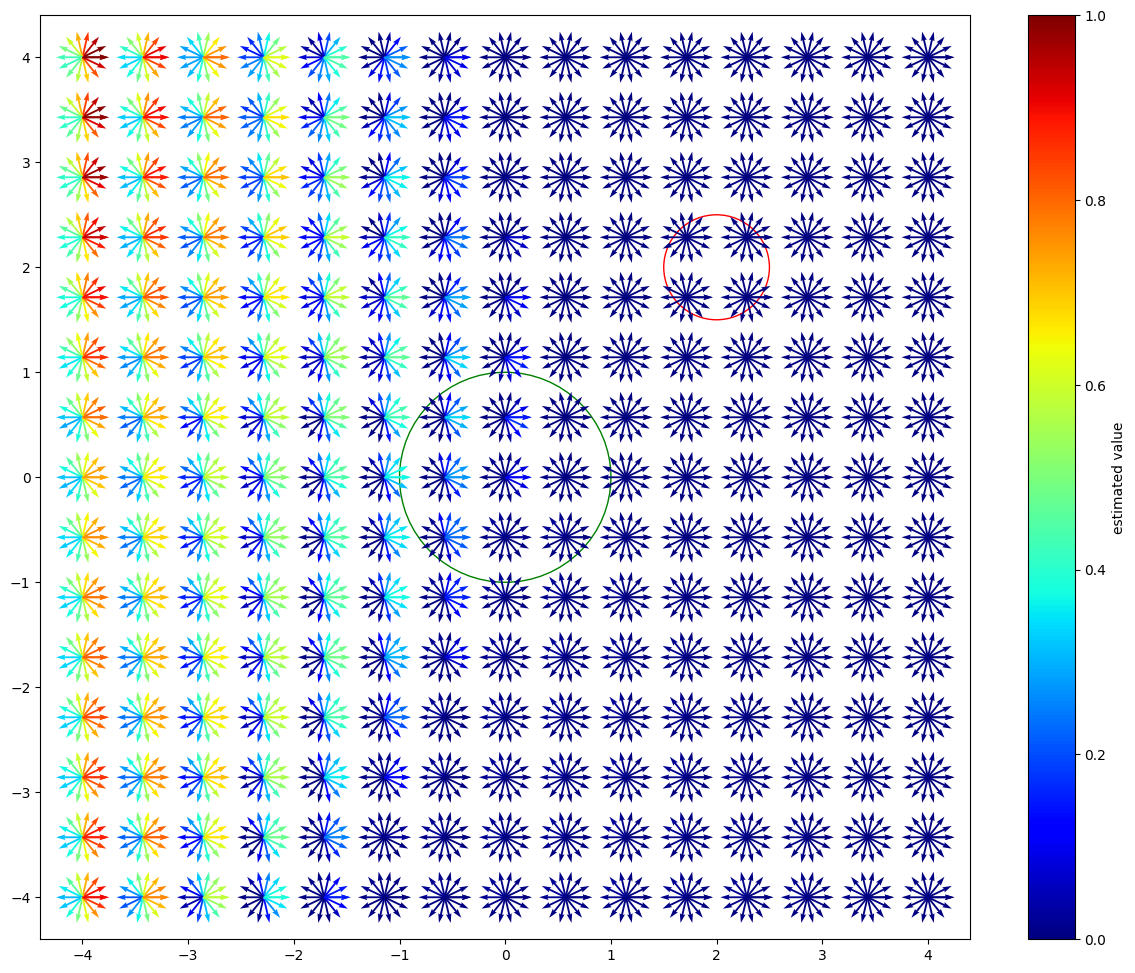

In [257]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm


# Plot...
plt.scatter(X_val[:,0], X_val[:,1], s=1) # s is a size of marker 
plt.jet()
plt.colorbar(label='estimated value')
#plt.savefig('500_iter_adabeleif_.85gamma.png')
#plt.show()

#draw goal
goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

# draw obstacle
obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
plt.gca().add_artist(obstacle)
plt.gca().add_artist(goal)


arrow_len = env.v_max
# Calculate arrow components
arrow_dx = arrow_len * np.cos(X_val[:,2])
arrow_dy = arrow_len * np.sin(X_val[:,2])

arrow_colors = cm.jet(y_pred/np.max(y_pred))


plt.quiver(X_val[:,0], X_val[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


plt.jet()
#plt.savefig('500_iter_adabeleif_.95gamma_grid.png')


In [233]:
arrow_colors

array([[[0.5, 0. , 0. , 1. ]],

       [[0.5, 0. , 0. , 1. ]],

       [[0.5, 0. , 0. , 1. ]],

       ...,

       [[0.5, 0. , 0. , 1. ]],

       [[0.5, 0. , 0. , 1. ]],

       [[0.5, 0. , 0. , 1. ]]])

In [252]:
#train on small steps, run on bigger steps?
right = 0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(3, -3, right)
#state = env.reset()

gamma = 0.85
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, a, update_env=False)
        #estimate = forward(X=next_state, params=params)
        estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)

        value = reward + gamma*estimate[0]
        print('estimate', value)
        print('state:',next_state)

        possible_actions.append(value)

    action = np.argmax(np.array(possible_actions))
    print('next_states', action, possible_actions)
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
env.make_gif()

estimate 0.0020738463
state: [ 3.25     -3.        5.148721]
estimate 0.0020738463
state: [ 3.25 -3.    0.  ]
estimate 0.0020738463
state: [ 3.25     -3.        1.134464]
next_states 0 [Array(0.00207385, dtype=float32), Array(0.00207385, dtype=float32), Array(0.00207385, dtype=float32)]
1
estimate 0.0020738463
state: [ 3.3556545 -3.226577   4.0142574]
estimate 0.0020738463
state: [ 3.3556545 -3.226577   5.148721 ]
estimate 0.0020738463
state: [ 3.3556545 -3.226577   6.283185 ]
next_states 0 [Array(0.00207385, dtype=float32), Array(0.00207385, dtype=float32), Array(0.00207385, dtype=float32)]
2
estimate 0.027060999
state: [ 3.1949575 -3.4180882  2.8797934]
estimate 0.00471019
state: [ 3.1949575 -3.4180882  4.0142574]
estimate 0.0020738463
state: [ 3.1949575 -3.4180882  5.148721 ]
next_states 0 [Array(0.027061, dtype=float32), Array(0.00471019, dtype=float32), Array(0.00207385, dtype=float32)]
3
estimate 0.018275002
state: [ 2.953476  -3.3533835  1.7453294]
estimate 0.028744973
state: [ 

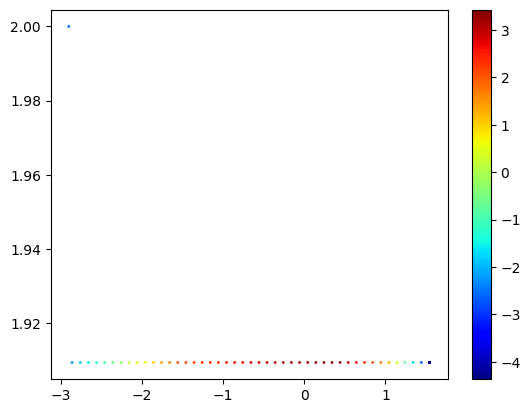

: 

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [ ]:
forward(X=np.array([3,3,0, 0]), params=params) 

Array([-2.9606214], dtype=float32)

: 

In [ ]:
forward(X=np.array([3,3,1, 1]), params=params) 

Array([-2.536736], dtype=float32)

: 

In [ ]:
#plot with arrows and try without obstacle. 

: 